In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
import os.path
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import scipy.stats


# Directory for data
data_dir = "/Users/yshiga/Documents/Research/Carbon_Machine/Monthly/"

Using TensorFlow backend.


In [2]:
# This code is a sandbox to help with the development of a neural network using monthly variables 
# over north america trained on inverse flux estimates
# There are a series of plotting and processing soce snippets
# I also borrow from https://www.tensorflow.org/tutorials/keras/regression exmaples for plotting epoch vs 
# loss performance


In [3]:
# grid mapping function
def data2grid(lats,lons,data):
    # create grid of lat lon (expand lat by 5 degrees)
    xi = np.arange(lons.min(), lons.max()+1,1)
    yi = np.arange(lats.min(), lats.max()+5,1)
    xi, yi = np.meshgrid(xi, yi)
    zi = np.zeros(yi.shape) # place holder for flux variable

    # loop over values, find index of lat & lon, enter flux variable
    for i in range(len(data)):
        min_temp_lat=abs(lats[i]-yi[:,0])
        min_temp_lon=abs(lons[i]-xi[0,:])
        lat_ind = (min_temp_lat == min(min_temp_lat))
        lon_ind = (min_temp_lon == min(min_temp_lon))
        zi[lat_ind,lon_ind]=data[i]
    return xi, yi, zi

In [4]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [5]:
def outlier_iqr(points,multiplier):
    q75, q25 = np.percentile(points, [75 ,25])
    iqr = q75 - q25
    

(282204, 1)
(12, 9, 1)


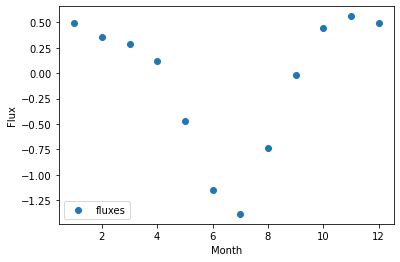

In [6]:
# Load in training fluxes, reshape, and transform scale

# filename for inverse carbon fluxes (units are umol/m2/s)
filename_flux = data_dir + "flux_training/geoinv-sif-monthly-2007-to-2015.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]

num_rows, num_cols = flux_var.shape # number of rows and columns

flux_var=flux_var.reshape((num_rows*num_cols, 1),) # reshape into one vector by stacking each column (month)

# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(flux_var, order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label="fluxes")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Flux')
plt.show()



In [7]:
flux_out=mad_based_outlier(flux_var)
sum(flux_out)

10955

(282204, 1)
(282204, 1)
(282204, 1)
(282204, 1)
(12, 9, 1)


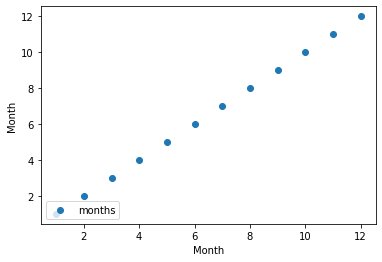

In [8]:
# load lat lon variables and create month variable
filename_narr = data_dir + "predictors/processed/narr-2007-NA-monthly.nc"
nc_narr = Dataset(filename_narr, 'r')  # open data file using netcdf reader
lat_var = np.array(nc_narr.variables["lat"]) # create numpy array note shape of lat vars is [space dimension ]
lon_var = np.array(nc_narr.variables["lon"]) # create numpy array note shape of lat vars is [space dimension ]

# tile to correct dimensions
lat_var_all=np.tile(lat_var,(1,12*9))
lon_var_all=np.tile(lon_var,(1,12*9))

# creat lat and lon variables
lat_var_all=np.transpose(lat_var_all)
lon_var_all=np.transpose(lon_var_all)

print(lon_var_all.shape)
print(lat_var_all.shape)

# create month variable
month_vec=[]
for months in range(1, 13):
    a=np.empty(2613); 
    a.fill(months)
    month_vec.extend(a)
    
month_vec=np.tile(month_vec,(1,9))
month_vec=np.transpose(month_vec)
print(month_vec.shape)



# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(month_vec, order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label="months")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Month')
plt.show()



(282204, 1)
(282204, 1)
(282204, 1)
(2613, 120)
(313560, 1)
(282204, 1)
(282204, 1)
(12, 9, 1)


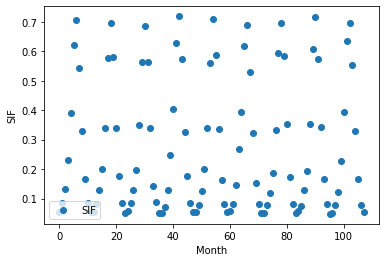

In [12]:
# load sif data 
filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_varR = np.array(nc_sif.variables["RSIF::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_varR.shape # number of rows and columns
sif_varR=sif_varR.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_varR=sif_varR[0:2613*9*12]
ind_sifR=np.isnan(sif_varR)
sif_varR[ind_sifR] = 0
print(sif_varR.shape)

filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var2A = np.array(nc_sif.variables["GOME2A::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var2A.shape # number of rows and columns
sif_var2A=sif_var2A.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var2A=sif_var2A[0:2613*9*12]
sif_var2A[np.isnan(sif_var2A)] = 0
print(sif_var2A.shape)


filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var2B = np.array(nc_sif.variables["GOME2B::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var2B.shape # number of rows and columns
sif_var2B=sif_var2B.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var2B=sif_var2B[0:2613*9*12]
sif_var2B[np.isnan(sif_var2B)] = 0
print(sif_var2B.shape)


filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_var_oco2 = np.array(nc_sif.variables["OCO2::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_var_oco2.shape # number of rows and columns
sif_var_oco2=sif_var_oco2.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_var_oco2=sif_var_oco2[0:2613*9*12]
sif_var_oco2[np.isnan(sif_var_oco2)] = 0

# ISSUE WITH MODIS DATA NEED TO DOUBLE CHECK HOW TIME IS STRUCTURED
# load NIRv data 
filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
nirv_var = np.array(nc_modis.variables["NIRv"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = nirv_var.shape # number of rows and columns\
print(nirv_var.shape)

nirv_var=nirv_var.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
print(nirv_var.shape)

nirv_var=nirv_var[0:2613*9*12]
nirv_var[np.isnan(nirv_var)] = 0
print(nirv_var.shape)

# # load NDVI data 
# filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
# nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
# ndvi_var = np.array(nc_modis.variables["NDVI"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
# num_rows, num_cols = ndvi_var.shape # number of rows and columns\
# print(ndvi_var.shape)

# ndvi_var=ndvi_var.reshape((num_rows*num_cols, 1)) # reshape into one vector by stacking each column (month)
# print(ndvi_var.shape)

# ndvi_var=ndvi_var[0:2613*9*12]
# ndvi_var[np.isnan(ndvi_var)] = 0
# print(ndvi_var.shape)

# #Time MODIS
# filename_modis = data_dir + "predictors/processed/modis-2007-to-2016-NA-monthly.nc"
# nc_modis = Dataset(filename_modis, 'r')  # open data file using netcdf reader
# time_var = np.array(nc_modis.variables["time"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
# print(time_var.shape)


# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
b = np.reshape(np.ravel(sif_varR, order='F'), (2613,12,9,-1),order='F')
a = np.reshape(np.ravel(nirv_var,order='F'), (2613,12,9,-1),order='F')
# c = np.reshape(np.ravel(ndvi_var,order='F'), (2613,12,9,-1),order='F')

# average by year
b = np.mean(b,axis=0)
a = np.mean(a,axis=0)
# c = np.mean(c,axis=0)

print(b.shape)
# average by month
#b = np.mean(b,axis=1)
b = b.reshape(1,12*9,order='F')

#a = np.mean(a,axis=1)
a = a.reshape(1,12*9,order='F')
# print(X_full_av_mon.shape)
# c = c.reshape(12*9,1,order='F')

# month variable
mon_array = np.arange(0, 12*9, dtype=float)
time_array = np.arange(0, 120, dtype=float)

# plot monthly averages averaged over all North America
# plt.scatter(mon_array,a,label="NIRv")
plt.scatter(mon_array,b,label="SIF")
# plt.scatter(mon_array,c,label="NDVI")
# plt.scatter(time_array,time_var,label="time var")

plt.legend(loc="lower left")
plt.ylabel('SIF')
# plt.ylabel('NDVI')

#plt.ylabel('NIRv')
plt.xlabel('Month')
plt.show()

(282204, 9)
(282204, 1)
(12, 9, 1)


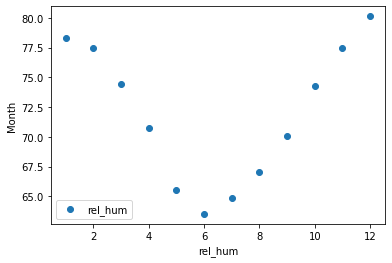

In [9]:
# load in NARR predictors
var_names = ['rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp','precip_16d','precip_30d']

final = []
# loop over variable names
for i in range(0, len(var_names)):
    final.append([]) # append to final
    for number in range(2007, 2016): # loop over years
        #print(number)
        filename_narr = data_dir + "predictors/processed/narr-%d-NA-monthly.nc" % number # file name per year yer variable
        nc_narr = Dataset(filename_narr, 'r')  # open data file using netcdf reader
        #print(i)
        narr_var = np.array(nc_narr.variables["{}".format(var_names[i])]) # create numpy array note shape of narr vars is [space dimension x time dimension] dimension]
        num_rows, num_cols = narr_var.shape # number of rows and columns
        final[i].extend(narr_var.reshape((num_rows*num_cols, 1),order='F')) # reshape into one vector by stacking each column (month)

# print(len(final))
# print(len(final[0]))
# print(len(final[0][0]))
X2 = np.array(final) # create numpy array from list

# print(X.shape)
X2 = np.transpose(np.squeeze(X2)) # transpose and remove singular dimension (squeeze)
print(X2.shape)



# double check shape/reshape order

# plot monthly average
print(flux_var.shape)

# reshape to average by month
num_var=0
b = np.reshape(np.ravel(X2[:,num_var], order='F'), (2613,12,9,-1),order='F')
# average by year
b = np.mean(b,axis=0)

print(b.shape)
# average by month
b = np.mean(b,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,b,label=var_names[num_var])
plt.legend(loc="lower left")

plt.xlabel(var_names[num_var])
plt.ylabel('Month')
plt.show()


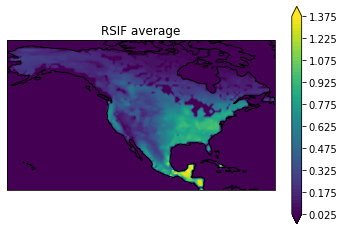

In [14]:
# plotting example

# plot SIF data
SIFR = sif_varR[0:2613*12].reshape(12,2613).mean(axis=0) # reshape and average

# use lat lon from **MODIS** variable ****<<<<<IMPORTANT>>>>>******
lats = nc_modis.variables['lat'][:]
lons = nc_modis.variables['lon'][:]

xi, yi, zi = data2grid(lats,lons,SIFR) # regrid for plotting

# set equal color limits for comparison 
#levels = np.linspace(-1.6, 1.6, 9)

# plot TRUTH

# projection axis
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi, 60,
             transform=ccrs.PlateCarree(),extend='both')
# add coasts
ax.coastlines()

# title
plt.title("RSIF average")
# color bar
plt.colorbar()
plt.show()

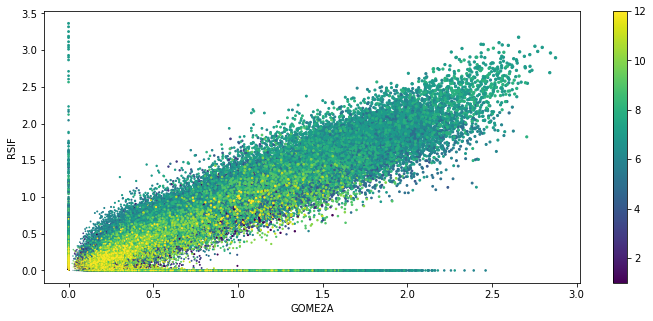

In [15]:
# test plot to visualize different sif products
fig, (ax1) = plt.subplots( 1,1,figsize=(12,5))

a1=ax1.scatter(sif_var2A[:,0], sif_varR[:,0],c=month_vec,s=abs(sif_var2A[:,0])+abs(sif_varR[:,0]))
ax1.set(ylabel='RSIF')
ax1.set(xlabel='GOME2A')
fig.colorbar(a1,ax=ax1)



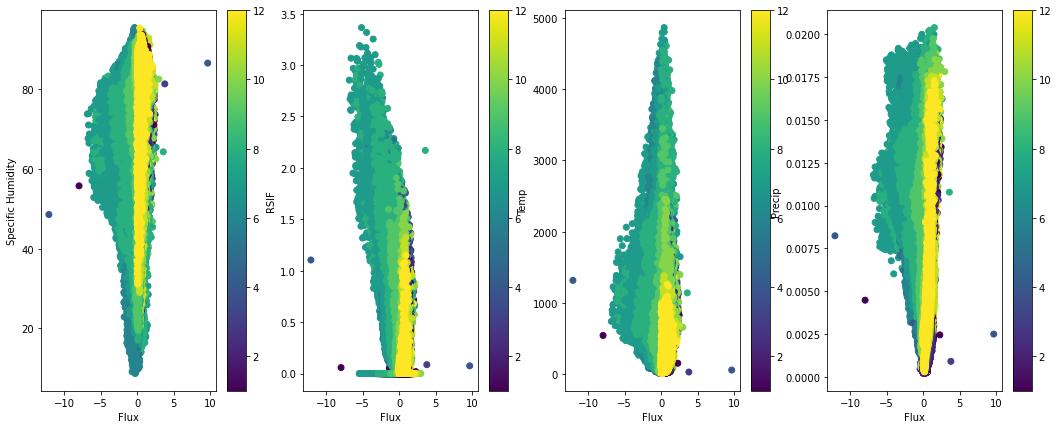

In [16]:
# try plotting variables against flux using month as color
fig, (ax1, ax2, ax3,ax4) = plt.subplots( 1,4,figsize=(18,7))

a1=ax1.scatter(flux_var, X2[:,0],c=month_vec)
ax1.set(ylabel='Specific Humidity')
ax1.set(xlabel='Flux')
fig.colorbar(a1,ax=ax1)

a2=ax2.scatter(flux_var, sif_varR[:,0],c=month_vec)
ax2.set(ylabel='RSIF')
ax2.set(xlabel='Flux')
fig.colorbar(a2,ax=ax2)

a3=ax3.scatter(flux_var, X2[:,5],c=month_vec)
ax3.set(ylabel='Temp')
ax3.set(xlabel='Flux')
fig.colorbar(a3,ax=ax3)


a4=ax4.scatter(flux_var, X2[:,1],c=month_vec)
ax4.set(ylabel='Precip')
ax4.set(xlabel='Flux')
fig.colorbar(a4,ax=ax4)

#fig.tight_layout() 

In [17]:
# Combine all predictors into one large matrix
# NARR, NIRv, Month
# X_full = np.concatenate((X2,sif_var,nirv_var,lon_var_all,lat_var_all,month_vec),axis=1)
var_names = ['rel_hum','sp_hum','precip','soil_moisture','R_sw','vpd','temp','precip_16d','precip_30d']

X_pars = X2[:,4:7] # radiation, vpd, temp, 30d precip
X_narr = np.concatenate((X2,month_vec),axis=1) # All NARR
X_pars_sif = np.concatenate((X_pars,sif_varR),axis=1) # 4 NARR plus sif
X_pars_2_sif = np.concatenate((X2[:,(0,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif
X_pars_3_sif = np.concatenate((X2[:,(0,2,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif
X_pars_4_sif = np.concatenate((X2[:,(2,3,4,5,6)],sif_varR),axis=1) # sp hum ,radiation, vpd, temp, 30d precip NARR plus sif

X_narr_sif_ll = np.concatenate((X2,sif_varR,month_vec,lat_var_all,lon_var_all),axis=1) # ALL NARR plus sif
X_narr_sif = np.concatenate((X2,sif_varR,month_vec),axis=1) # ALL NARR plus sif

X_pars_4_sif_m = np.concatenate((X2[:,(2,3,4,5,6)],sif_varR,month_vec),axis=1) # 'precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month




## DEFINE MODEL HERE ###





X_full = X_pars_4_sif_m








print(X_full.shape[1])












7


In [18]:
# Create pandas dataframe 
col_names = var_names + ['SIF' , 'Month','Flux']
print(col_names)
df = pd.DataFrame(np.concatenate((X_narr_sif,flux_var),axis=1), columns = col_names)

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

['rel_hum', 'sp_hum', 'precip', 'soil_moisture', 'R_sw', 'vpd', 'temp', 'precip_16d', 'precip_30d', 'SIF', 'Month', 'Flux']


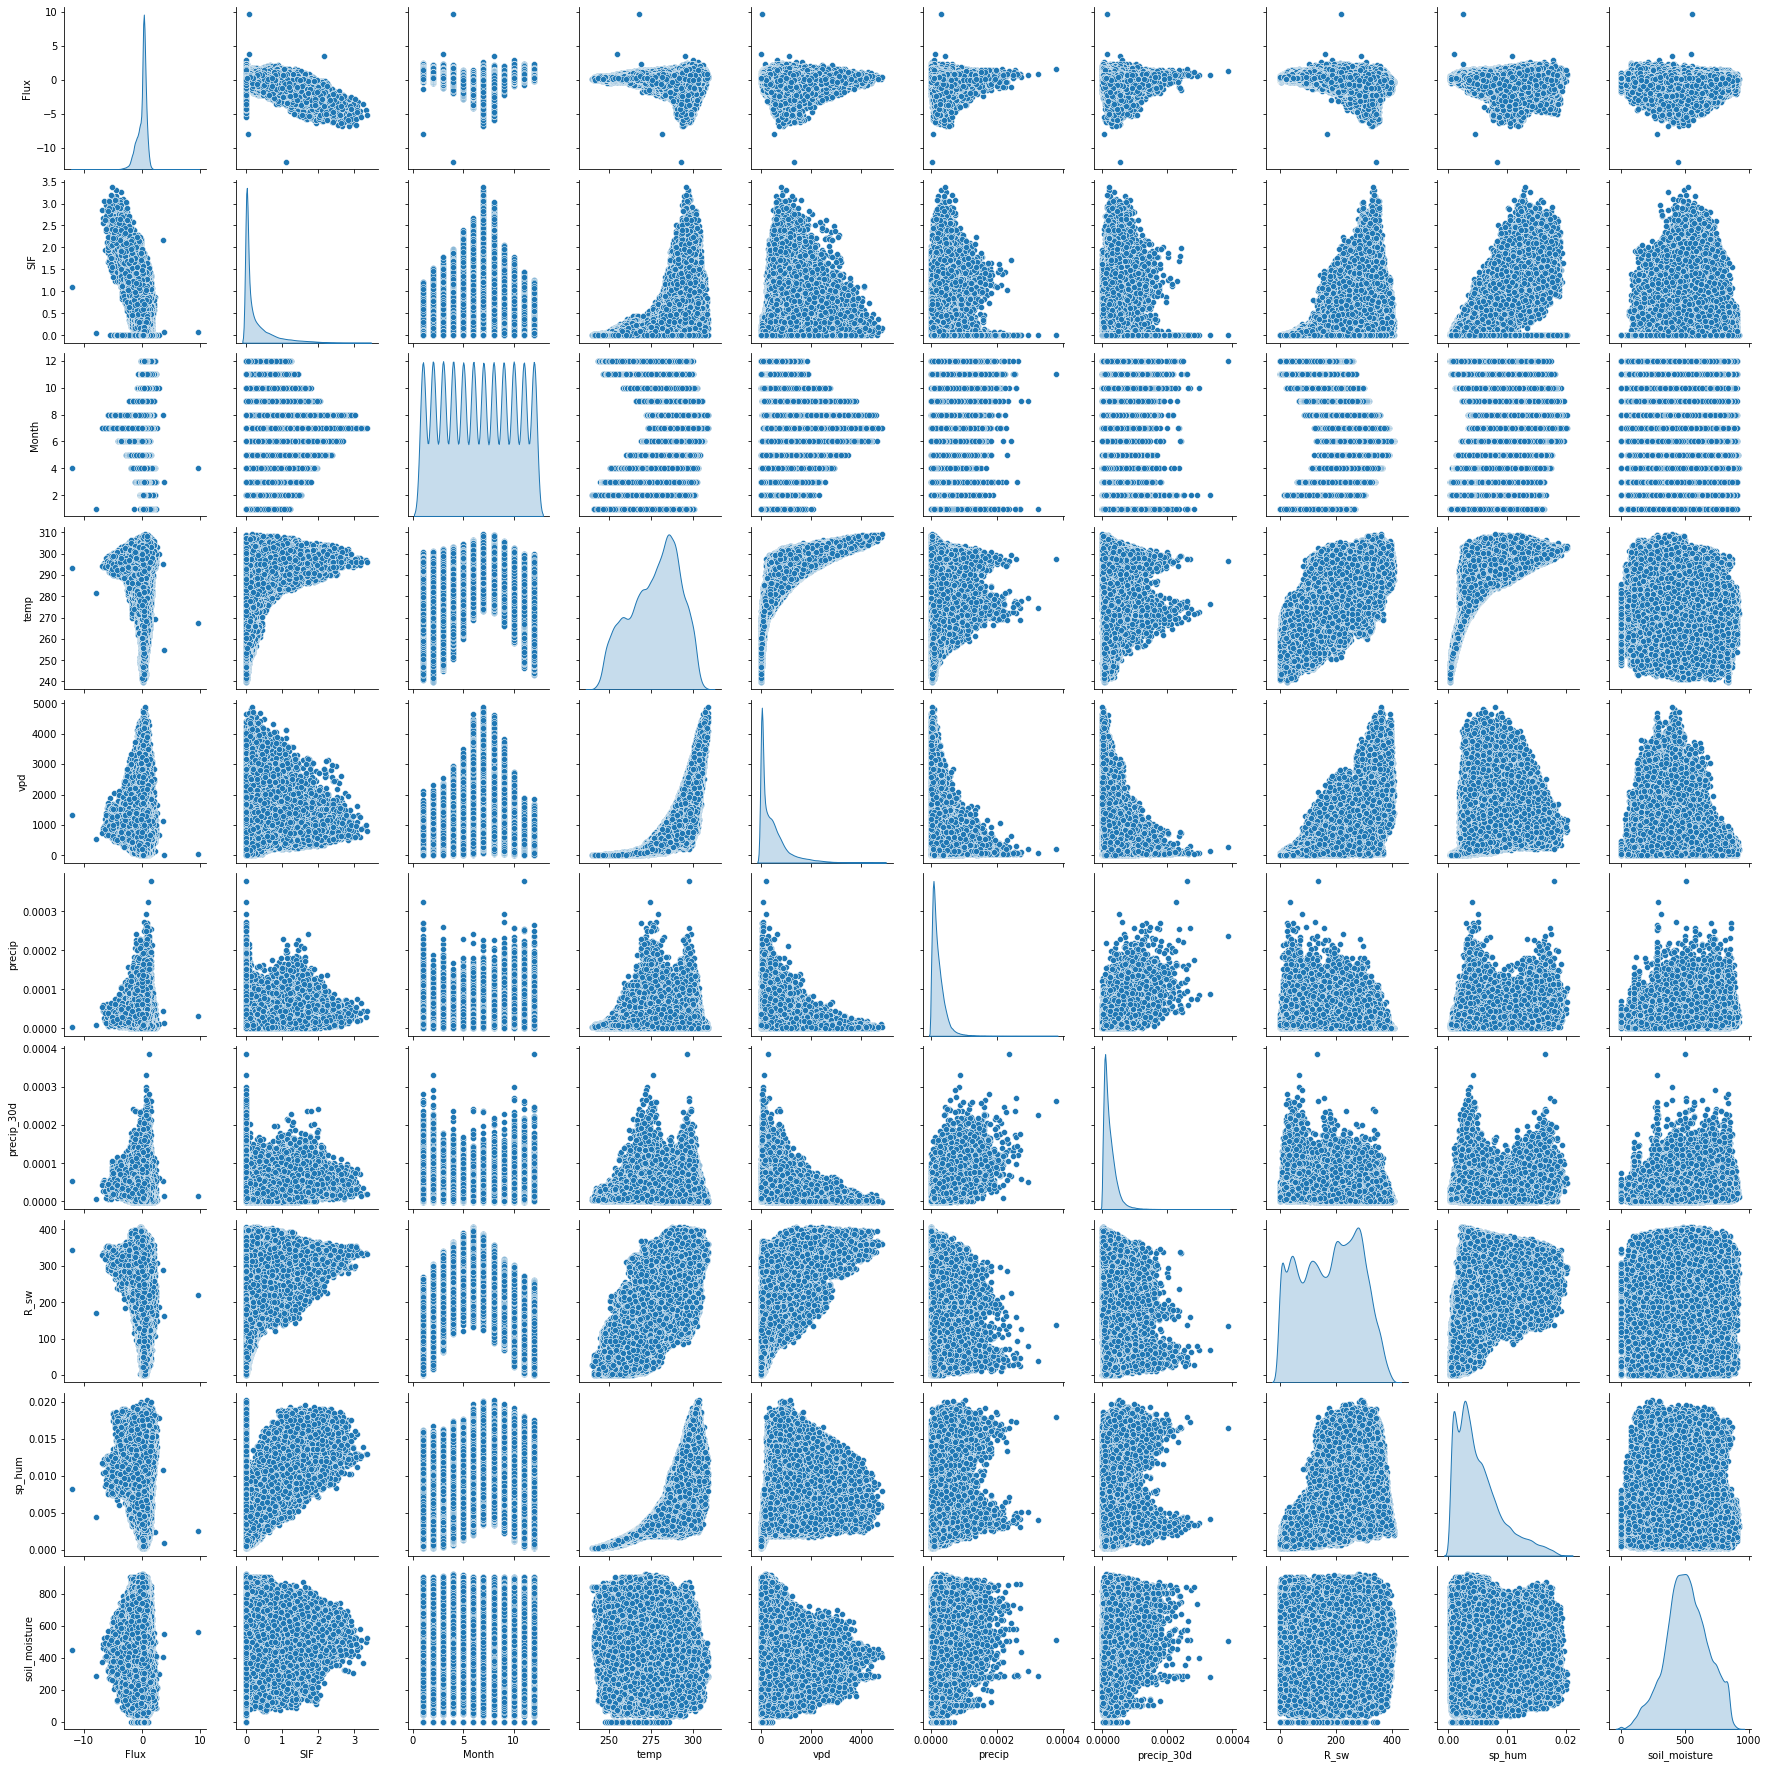

In [19]:
sns.pairplot(train_dataset[['Flux', 'SIF', 'Month', 'temp','vpd','precip','precip_30d','R_sw','sp_hum','soil_moisture']], diag_kind='kde')


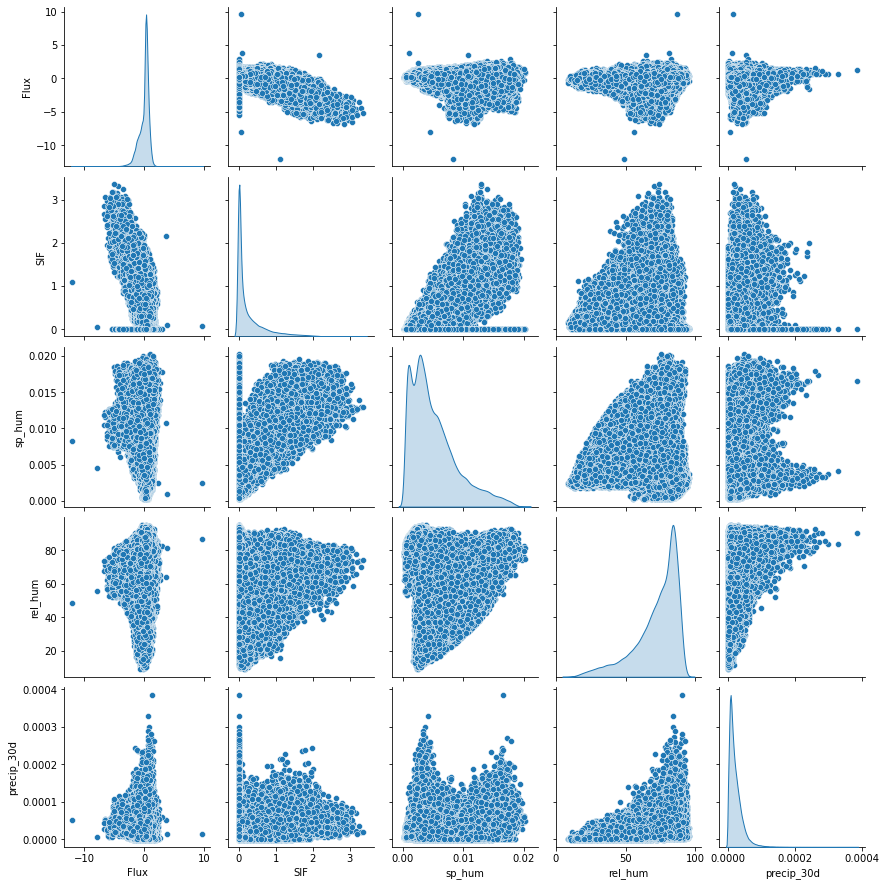

In [20]:
sns.pairplot(train_dataset[['Flux', 'SIF', 'sp_hum','rel_hum','precip_30d']], diag_kind='kde')


In [21]:
# Split into Train and test
# Then transform

X_train = X_full[0:2613*8*12,:] # train on first 8 years
y_train = flux_var[0:2613*8*12] # train on first 8 years

X_test = X_full[2613*8*12:,:] # test on last year
y_test = flux_var[2613*8*12:] # test on last year

# transform for NN

# scaler_x = preprocessing.StandardScaler() # scaling zero mean unit variance
#scaler_y = preprocessing.StandardScaler() # scaling zero mean unit variance

# scale predictors between 0-1
scaler_x_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_train.fit(X_train)
#scaler_y_train = preprocessing.MinMaxScaler(feature_range=(0, 1))

# try quantile transformation of flux data see: https://machinelearningmastery.com/quantile-transforms-for-machine-learning/
scaler_y_train = QuantileTransformer(random_state=0)
scaler_y_train.fit(y_train)

X_train = scaler_x_train.fit_transform(X_train) # transform training predictors data
y_train = scaler_y_train.fit_transform(y_train) # transform training flux data

scaler_x_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_test.fit(X_test)

#scaler_y_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_y_test = QuantileTransformer(random_state=0)
scaler_y_test.fit(y_test)


X_test = scaler_x_test.fit_transform(X_test) # transform test predictors data
y_test = scaler_y_test.fit_transform(y_test) # transform test flux data

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(250848, 7)
(250848, 1)
(31356, 7)
(31356, 1)


In [24]:
# Building a linear model  (see : https://www.tensorflow.org/tutorials/keras/regression)
linear_model = Sequential()
linear_model.add(Dense(1,input_dim=X_full.shape[1], activation='linear'))

x = tf.ones((1, X_full.shape[1]))
yt = linear_model(x)
print("Number of weights after calling the model:", len(linear_model.weights))  # 6

#model.add(Dense(4, input_dim=8,activation='sigmoid',kernel_initializer='normal'))
#model.add(Dense(1, activation='linear',kernel_initializer='normal'))

optimizer = keras.optimizers.sgd()
#optimizer = keras.optimizers.adam()

# model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
linear_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])


print(linear_model.weights)

Number of weights after calling the model: 2
[<tf.Variable 'dense_1/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[ 0.23693329],
       [-0.7540676 ],
       [ 0.71749073],
       [ 0.05070591],
       [-0.14313942],
       [ 0.04942471],
       [ 0.79387563]], dtype=float32)>, <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [25]:
# Training
history = linear_model.fit(
    X_train, y_train, 
    epochs=4,
    # suppress logging
    verbose=0,
    batch_size = 264,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)


In [26]:
history.history

{'val_loss': [0.22810485950291146,
  0.19806647471027686,
  0.19164870956996916,
  0.18857451404649256],
 'val_mae': [0.22810491919517517,
  0.19806653261184692,
  0.1916486918926239,
  0.18857453763484955],
 'loss': [0.3070179523255273,
  0.2113035890912994,
  0.19544121189796362,
  0.18866526434064976],
 'mae': [0.3070179, 0.21130362, 0.19544125, 0.18866536]}

In [33]:
# create plotting function *** note ylim and values from history ****
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, .35])
  plt.xlabel('Epoch')
  plt.ylabel('MAE Error [flux]')
  plt.legend()
  plt.grid(True)


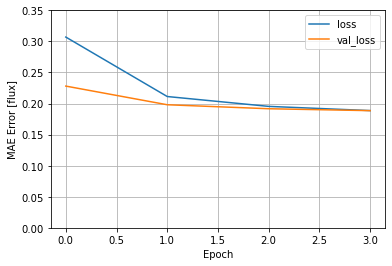

In [34]:
plot_loss(history)

In [35]:
test_results ={}
test_results['linear_model'] = linear_model.evaluate(
    X_train, y_train, verbose=0)

[[1.         0.48154353]
 [0.48154353 1.        ]]
[-2643.08289804]
[-4489.0903]
-0.08429273179117278
-0.14316507


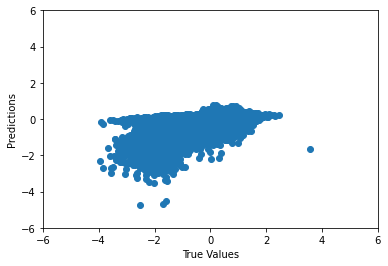

In [36]:
# Scatter plot of estimates and test values
y_est = scaler_y_test.inverse_transform(linear_model.predict(X_test))

a = plt.axes

plt.scatter(scaler_y_test.inverse_transform(y_test),y_est )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim(-6, 6)   # set the xlim to left, right
plt.xlim(-6, 6)  

var1=scaler_y_test.inverse_transform(y_test)
var2=y_est

# Basic stats on test predictions

# calculate correlation coefficient
print(np.corrcoef(var1,var2,rowvar=False))
# Calculate sum
print(sum(var1))
print(sum(var2))

# Calculate mean

print(np.mean(var1))
print(np.mean(var2))

In [37]:
# Building a model
simple_model = Sequential()
simple_model.add(Dense(19,input_dim=X_full.shape[1], activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

x = tf.ones((1, X_full.shape[1]))
yt = simple_model(x)
print("Number of weights after calling the model:", len(simple_model.weights))  # 6

#model.add(Dense(4, input_dim=8,activation='sigmoid',kernel_initializer='normal'))
#model.add(Dense(1, activation='linear',kernel_initializer='normal'))

#optimizer = keras.optimizers.sgd()
optimizer = keras.optimizers.adam(0.1)

# model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
simple_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])


#print(simple_model.weights)

Number of weights after calling the model: 4


In [38]:
# Training
history_simple = simple_model.fit(
    X_train, y_train, 
    epochs=20,
    # suppress logging
    verbose=0,
    batch_size = 264,
    # Calculate validation results on 20% of the training data
     validation_split = 0.2)

In [39]:
# Training
history_simple_pars_2 = simple_model.fit(
    X_train, y_train, 
    epochs=20,
    # suppress logging
    verbose=0,
    batch_size = 264,
    # Calculate validation results on 20% of the training data
     validation_split = 0.2)

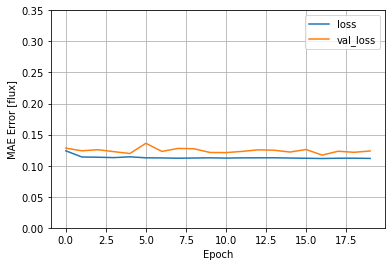

In [40]:
plot_loss(history_simple)

In [41]:
test_results['simple_model'] = simple_model.evaluate(
    X_train, y_train, verbose=0)

[[1.        0.8873374]
 [0.8873374 1.       ]]
[-2643.08289804]
[-492.2085]
-0.08429273179117278
-0.01569632


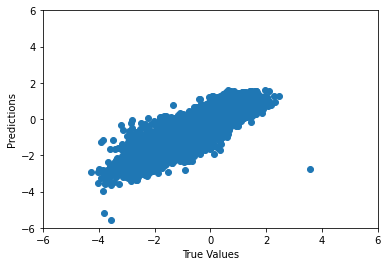

In [65]:
y_est = scaler_y_test.inverse_transform(simple_model.predict(X_test))

a = plt.axes

plt.scatter(scaler_y_test.inverse_transform(y_test),y_est )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim(-6, 6)   # set the xlim to left, right
plt.xlim(-6, 6)  
var1=scaler_y_test.inverse_transform(y_test)
var2=y_est

# Basic stats on test predictions

# calculate correlation coefficient
print(np.corrcoef(var1,var2,rowvar=False))
# Calculate sum
print(sum(var1)) # sum of truth
print(sum(var2)) # sum of estimates

# Calculate mean

print(np.mean(var1)) # mean of truth
print(np.mean(var2)) # mean of estimates

In [66]:
pd.DataFrame(test_results).T


,0,1
linear_model,0.186672,0.186672
simple_model,0.111777,0.111777
simple_model_2,0.101517,0.101517


In [67]:
simple_model.evaluate(
    X_test, y_test, verbose=0)

[0.11274921587838371, 0.11274925619363785]

In [68]:
linear_model.evaluate(
    X_test, y_test, verbose=0)

[0.18789544681046505, 0.18789535760879517]

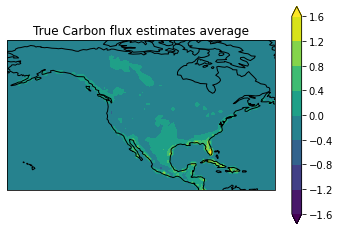

In [69]:
# plotting example for test data (not included in training aka 9th year = 2015)

# plot flux data
flux = y_est.reshape(12,2613).mean(axis=0) # reshape and average
flux_test = flux_var[2613*8*12:]
fluxt = flux_test.reshape(12,2613).mean(axis=0) # reshape and average

# use lat lon from **MODIS** variable ****<<<<<IMPORTANT>>>>>******
lats = nc_modis.variables['lat'][:]
lons = nc_modis.variables['lon'][:]

xi, yi, zi_flux = data2grid(lats,lons,flux) # regrid for plotting "truth"
xt, yt, zt_flux = data2grid(lats,lons,fluxt) # regrid for plotting "model"


xd, yd, zd_flux = data2grid(lats,lons,flux-fluxt) # regrid for plotting "truth-model"

# set equal color limits for comparison 
levels = np.linspace(-1.6, 1.6, 9)

# plot TRUTH

# projection axis
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zt_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')
# add coasts
ax.coastlines()

# title
plt.title("True Carbon flux estimates average")
# color bar
plt.colorbar()
plt.show()

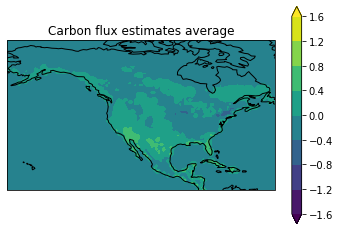

In [70]:
# plot estimates
# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(-1.6, 1.6, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')
# plt.clim(-1.6,1.6)

# add coasts
ax.coastlines()

# title
plt.title("Carbon flux estimates average")
plt.colorbar()
plt.show()

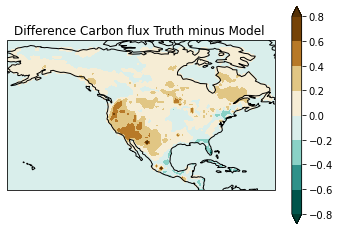

In [71]:
# plot estimates
# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(-.8, .8, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xd, yd, zd_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),cmap= 'BrBG_r',extend='both')
# plt.clim(-1.6,1.6)

# add coasts
ax.coastlines()

# title
plt.title("Difference Carbon flux Truth minus Model ")
plt.colorbar()
plt.show()

(31356, 1)
(31356, 1)
(12, 1, 1)


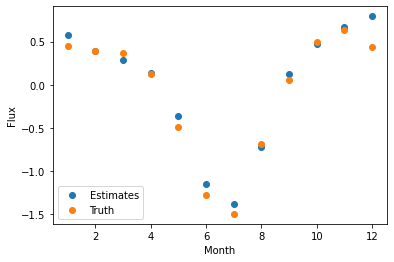

In [72]:
# plot monthly averages
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
b = np.reshape(np.ravel(flux_test, order='F'), (2613,12,1,-1),order='F')
a = np.reshape(np.ravel(y_est, order='F'), (2613,12,1,-1),order='F') 
# average by year
X_test_mon = np.mean(a,axis=0)
X_tru_mon = np.mean(b,axis=0)

print(X_test_mon.shape)
# average by month
X_test_mon = np.mean(X_test_mon,axis=1)
X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,X_test_mon[:,0],label="Estimates")
plt.scatter(mon_array,X_tru_mon[:,0],label="Truth")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Flux')
plt.show()


(31356, 1)
(31356, 1)
(12, 1)


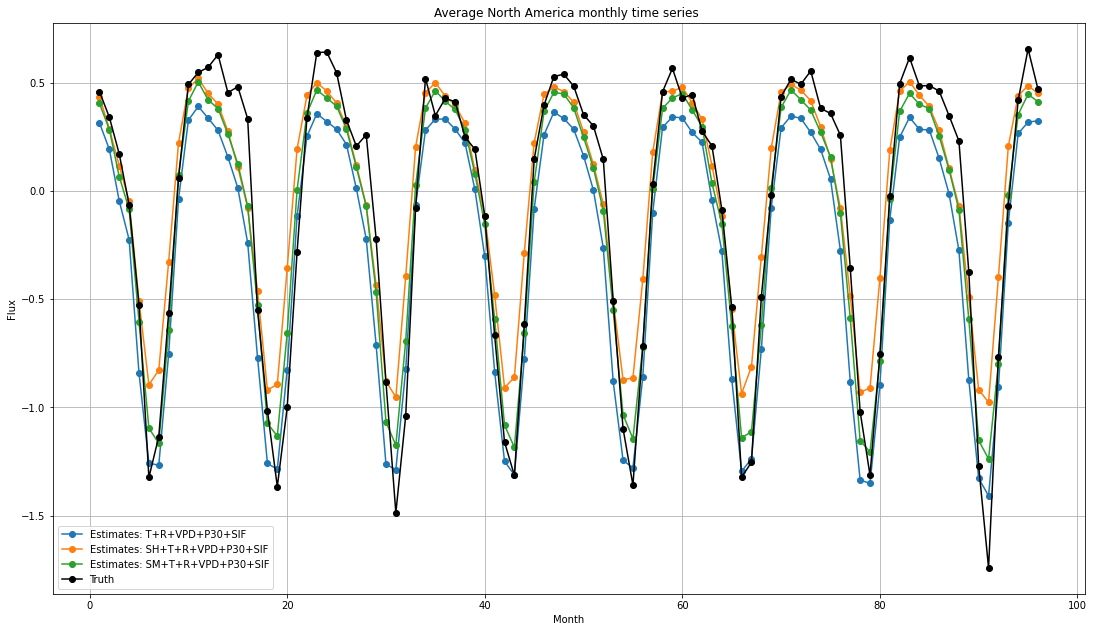

In [279]:
#y_est_train_all = scaler_y_test.inverse_transform(simple_model.predict(X_train))
y_est_train_all_b = scaler_y_test.inverse_transform(simple_2_model.predict(X_train))

y_train_orig = flux_var[0:2613*8*12] # train on first 8 years

# plot monthly timeseries
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
b = np.reshape(np.ravel(y_train_orig, order='F'), (2613,12,8,-1),order='F')
a_1 = np.reshape(np.ravel(y_est_train_1, order='F'), (2613,12,8,-1),order='F') 
a_2 = np.reshape(np.ravel(y_est_train_2, order='F'), (2613,12,8,-1),order='F') 
a_22 = np.reshape(np.ravel(y_est_train_22, order='F'), (2613,12,8,-1),order='F') 
a_3 = np.reshape(np.ravel(y_est_train_3, order='F'), (2613,12,8,-1),order='F') 
a_3b = np.reshape(np.ravel(y_est_train_3b, order='F'), (2613,12,8,-1),order='F') 
a_4 = np.reshape(np.ravel(y_est_train_4, order='F'), (2613,12,8,-1),order='F') 
a_5 = np.reshape(np.ravel(y_est_train_all, order='F'), (2613,12,8,-1),order='F') 
a_5b = np.reshape(np.ravel(y_est_train_all_b, order='F'), (2613,12,8,-1),order='F') 

# average by year
X_test_mon_1 = np.reshape(np.mean(a_1,axis=0),(1,-1),order='F')
X_test_mon_2 = np.reshape(np.mean(a_2,axis=0),(1,-1),order='F')
X_test_mon_22 = np.reshape(np.mean(a_22,axis=0),(1,-1),order='F')
X_test_mon_3 = np.reshape(np.mean(a_3,axis=0),(1,-1),order='F')
X_test_mon_3b = np.reshape(np.mean(a_3b,axis=0),(1,-1),order='F')
X_test_mon_4 = np.reshape(np.mean(a_4,axis=0),(1,-1),order='F')
X_test_mon_5 = np.reshape(np.mean(a_5,axis=0),(1,-1),order='F')
X_test_mon_5b = np.reshape(np.mean(a_5b,axis=0),(1,-1),order='F')

X_tru_mon = np.reshape(np.mean(b,axis=0),(1,-1),order='F')

print(X_test_mon.shape)
# average by month
#X_test_mon = np.mean(X_test_mon,axis=1)
#X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1,97 ,dtype=float)
# plot monthly averages averaged over all North America
plt.plot(mon_array,X_test_mon_1[0,:],'-o',label="Estimates: T+R+VPD+P30+SIF")
plt.plot(mon_array,X_test_mon_2[0,:],'-o',label="Estimates: SH+T+R+VPD+P30+SIF")
plt.plot(mon_array,X_test_mon_4[0,:],'-o',label="Estimates: SM+T+R+VPD+P30+SIF")
plt.plot(mon_array,X_test_mon_3[0,:],'-o',label="Estimates: SH+SM+T+R+VPD+P30+SIF")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL (extra layer)")

plt.plot(mon_array,X_tru_mon[0,:],'-ok',label="Truth")
plt.legend(loc="lower left")


plt.title("Average North America monthly time series ")

plt.xlabel('Month')
plt.ylabel('Flux')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.grid()
plt.show()


(31356, 1)
(31356, 1)
(12, 1)


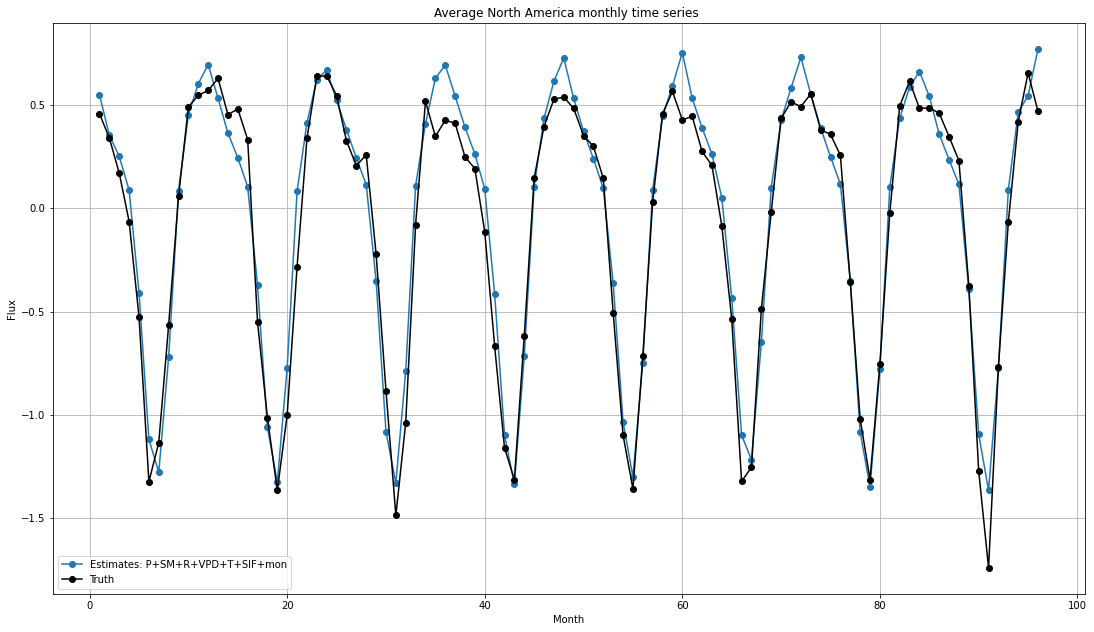

In [48]:
#y_est_train_all = scaler_y_test.inverse_transform(simple_model.predict(X_train))
y_est_train_m = scaler_y_test.inverse_transform(simple_model.predict(X_train))

y_train_orig = flux_var[0:2613*8*12] # train on first 8 years

# plot monthly timeseries
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
mod_m = np.reshape(np.ravel(y_est_train_m, order='F'), (2613,12,8,-1),order='F')
tru = np.reshape(np.ravel(y_train_orig, order='F'), (2613,12,8,-1),order='F')
# average by year
X_test_mod_m = np.reshape(np.mean(mod_m,axis=0),(1,-1),order='F')

X_tru_mon = np.reshape(np.mean(tru,axis=0),(1,-1),order='F')

print(X_test_mon.shape)
# average by month
#X_test_mon = np.mean(X_test_mon,axis=1)
#X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1,97 ,dtype=float)
# plot monthly averages averaged over all North America
#precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month

plt.plot(mon_array,X_test_mod_m[0,:],'-o',label="Estimates: P+SM+R+VPD+T+SIF+mon")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL (extra layer)")

plt.plot(mon_array,X_tru_mon[0,:],'-ok',label="Truth")
plt.legend(loc="lower left")


plt.title("Average North America monthly time series ")

plt.xlabel('Month')
plt.ylabel('Flux')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.grid()
plt.show()


(31356, 1)
(31356, 1)
(12, 1)


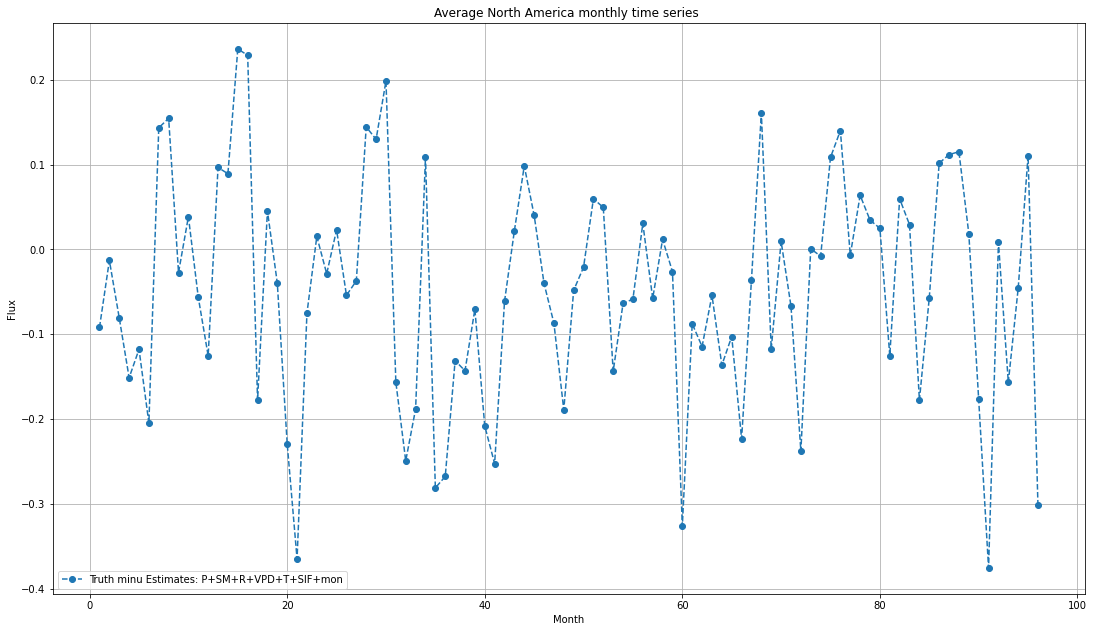

In [77]:
#y_est_train_all = scaler_y_test.inverse_transform(simple_model.predict(X_train))
y_est_train_m = scaler_y_test.inverse_transform(simple_model.predict(X_train))

y_train_orig = flux_var[0:2613*8*12] # train on first 8 years

# plot monthly timeseries
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
mod_m = np.reshape(np.ravel(y_est_train_m, order='F'), (2613,12,8,-1),order='F')
tru = np.reshape(np.ravel(y_train_orig, order='F'), (2613,12,8,-1),order='F')
# average by year
X_test_mod_m = np.reshape(np.mean(mod_m,axis=0),(1,-1),order='F')

X_tru_mon = np.reshape(np.mean(tru,axis=0),(1,-1),order='F')

print(X_test_mon.shape)
# average by month
#X_test_mon = np.mean(X_test_mon,axis=1)
#X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1,97 ,dtype=float)
# plot monthly averages averaged over all North America
#precip','soil_moisture','R_sw','vpd','temp', NARR plus sif and month

plt.plot(mon_array,X_tru_mon[0,:]-X_test_mod_m[0,:],'--o',label="Truth minu Estimates: P+SM+R+VPD+T+SIF+mon")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL")
#plt.plot(mon_array,X_test_mon_5[0,:],'-o',label="Estimates: ALL (extra layer)")

plt.legend(loc="lower left")


plt.title("Average North America monthly time series ")

plt.xlabel('Month')
plt.ylabel('Flux')
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.grid()
plt.show()

0.9606584432313661
0.006923741500619373


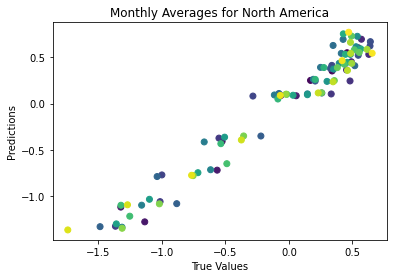

In [79]:
# Plot monthly NA average scatter truth vs est
plt.scatter(X_tru_mon[0,:],X_test_mod_m[0,:],c=mon_array)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Monthly Averages for North America')
C_mon=np.corrcoef(X_tru_mon[0,:],X_test_mod_m[0,:],rowvar=False)
print(np.square(C_mon[0,1]))
C_space=np.corrcoef(zi_flux,zt_flux,rowvar=False)
print(np.square(C_space[0,1]))


Text(0.5, 1.0, 'Grid cell annual averages for North America')

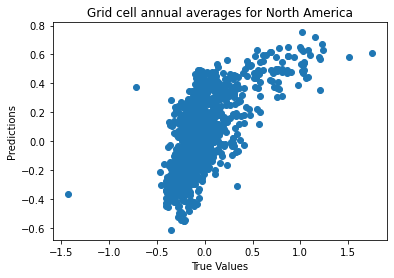

In [80]:
# Plot grid cell annual average scatter truth vs est

plt.scatter(zt_flux,zi_flux)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Grid cell annual averages for North America')

In [137]:
# Combine all predictors into one large matrix
# NARR, NIRv, Month
# X_full = np.concatenate((X2,sif_var,nirv_var,lon_var_all,lat_var_all,month_vec),axis=1)
X_pars = np.concatenate((X2[:,3:6],month_vec),axis=1) # radiation, vpd, temp, 30d precip
X_narr = np.concatenate((X2,month_vec),axis=1) # All NARR
X_narr_sif = np.concatenate((X2,sif_var2A,month_vec),axis=1) # ALL NARR plus sif


X_full = X_narr
print(X_full.shape[1])

8


In [138]:
# Split into Train and test
# Then transform

X_train = X_full[0:2613*8*12,:] # train on first 8 years
y_train = flux_var[0:2613*8*12] # train on first 8 years

X_test = X_full[2613*8*12:,:] # test on last year
y_test = flux_var[2613*8*12:] # test on last year

# transform for NN

# scaler_x = preprocessing.StandardScaler() # scaling zero mean unit variance
#scaler_y = preprocessing.StandardScaler() # scaling zero mean unit variance

# scale predictors between 0-1
scaler_x_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_train.fit(X_train)
#scaler_y_train = preprocessing.MinMaxScaler(feature_range=(0, 1))

# try quantile transformation of flux data see: https://machinelearningmastery.com/quantile-transforms-for-machine-learning/
scaler_y_train = QuantileTransformer(random_state=0)
scaler_y_train.fit(y_train)

X_train = scaler_x_train.fit_transform(X_train) # transform training predictors data
y_train = scaler_y_train.fit_transform(y_train) # transform training flux data

scaler_x_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_x_test.fit(X_test)

#scaler_y_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler_y_test = QuantileTransformer(random_state=0)
scaler_y_test.fit(y_test)


X_test = scaler_x_test.fit_transform(X_test) # transform test predictors data
y_test = scaler_y_test.fit_transform(y_test) # transform test flux data

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(250848, 8)
(250848, 1)
(31356, 8)
(31356, 1)


In [140]:
# Building a model
narr_2_model = Sequential()
narr_2_model.add(Dense(12,input_dim=X_full.shape[1], activation='relu'))
narr_2_model.add(Dense(12, activation='relu'))
narr_2_model.add(Dense(1, activation='linear'))

x = tf.ones((1, X_full.shape[1]))
yt = narr_2_model(x)
print("Number of weights after calling the model:", len(simple_2_model.weights))  # 6

#model.add(Dense(4, input_dim=8,activation='sigmoid',kernel_initializer='normal'))
#model.add(Dense(1, activation='linear',kernel_initializer='normal'))

#optimizer = keras.optimizers.sgd()
optimizer = keras.optimizers.adam(0.001)

# model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
narr_2_model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])


#print(simple_2_model.weights)

Number of weights after calling the model: 6


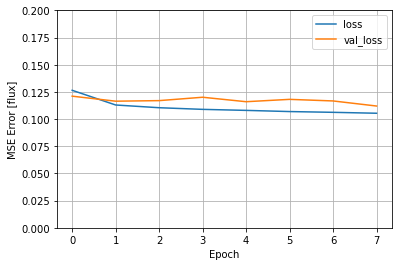

In [141]:
# Training
history_narr_2 = narr_2_model.fit(
    X_train, y_train, 
    epochs=8,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

plot_loss(history_narr_2)

test_results['narr_model_2'] = narr_2_model.evaluate(
    X_train, y_train, verbose=0)

[[1.         0.83878981]
 [0.83878981 1.        ]]
[-2643.08289804]
[-2141.0596]
-0.08429273179117278
-0.06828249


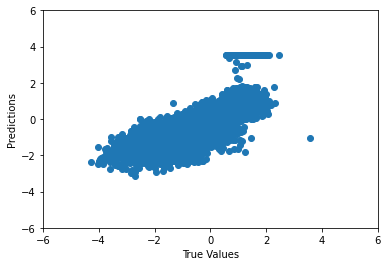

In [142]:
y_est = scaler_y_test.inverse_transform(narr_2_model.predict(X_test))
y_est_train = scaler_y_test.inverse_transform(narr_2_model.predict(X_train))

a = plt.axes

plt.scatter(scaler_y_test.inverse_transform(y_test),y_est )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.ylim(-6, 6)   # set the xlim to left, right
plt.xlim(-6, 6)  


var1=scaler_y_test.inverse_transform(y_test)
var2=y_est

# Basic stats on test predictions

# calculate correlation coefficient
print(np.corrcoef(var1,var2,rowvar=False))
# Calculate sum
print(sum(var1))
print(sum(var2))

# Calculate mean

print(np.mean(var1))
print(np.mean(var2))

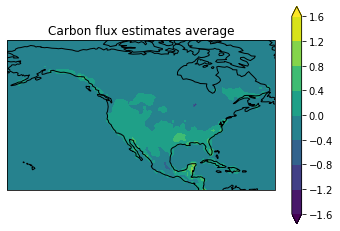

In [143]:
# plot estimates
flux = y_est.reshape(12,2613).mean(axis=0) # reshape and average
xi, yi, zi_flux = data2grid(lats,lons,flux) # regrid for plotting

# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(-1.6, 1.6, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')
# plt.clim(-1.6,1.6)

# add coasts
ax.coastlines()

# title
plt.title("Carbon flux estimates average")
plt.colorbar()
plt.show()

(31356, 1)
(31356, 1)
(12, 1, 1)


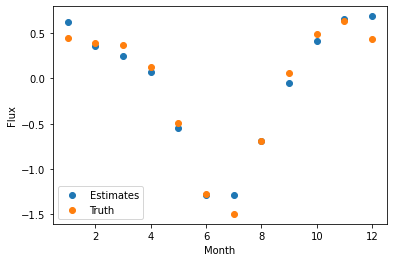

In [144]:
# plot monthly average
print(flux_test.shape)
print(y_est.shape)

# reshape to average by month
b = np.reshape(np.ravel(flux_test, order='F'), (2613,12,1,-1),order='F')
a = np.reshape(np.ravel(y_est, order='F'), (2613,12,1,-1),order='F') 
# average by year
X_test_mon = np.mean(a,axis=0)
X_tru_mon = np.mean(b,axis=0)

print(X_test_mon.shape)
# average by month
X_test_mon = np.mean(X_test_mon,axis=1)
X_tru_mon = np.mean(X_tru_mon,axis=1)

# print(X_full_av_mon.shape)

# month variable
mon_array = np.arange(1, 13, dtype=float)

# plot monthly averages averaged over all North America
plt.scatter(mon_array,X_test_mon[:,0],label="Estimates")
plt.scatter(mon_array,X_tru_mon[:,0],label="Truth")
plt.legend(loc="lower left")

plt.xlabel('Month')
plt.ylabel('Flux')
plt.show()


0.9702322966810023
0.5008849551023707


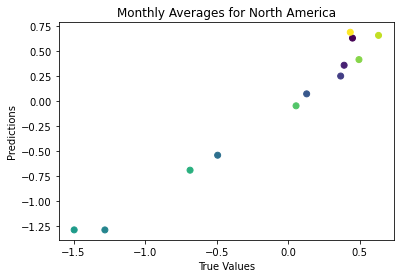

In [145]:
# Plot monthly NA average scatter truth vs est
plt.scatter(X_tru_mon[:,0],X_test_mon[:,0],c=mon_array)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Monthly Averages for North America')
C_mon=np.corrcoef(X_tru_mon,X_test_mon,rowvar=False)
print(np.square(C_mon[0,1]))
C_space=np.corrcoef(zi_flux,zt_flux,rowvar=False)
print(np.square(C_space[0,1]))


Text(0.5, 1.0, 'Grid cell annual averages for North America')

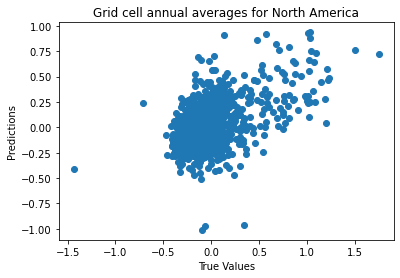

In [146]:
# Plot grid cell annual average scatter truth vs est

plt.scatter(zt_flux,zi_flux)

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Grid cell annual averages for North America')

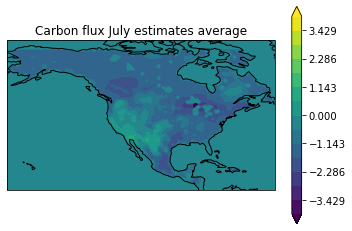

In [179]:
# plot montthly estimates
flux = y_est.reshape(12,2613).mean(axis=0) # reshape and average
a = np.reshape(np.ravel(y_est, order='F'), (2613,12,1,-1),order='F') 

xi, yi, zi_flux = data2grid(lats,lons,a[:,6]) # regrid for plotting

# projection axis  
ax = plt.axes(projection=ccrs.PlateCarree())
levels = np.linspace(-4, 4, 15)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
             transform=ccrs.PlateCarree(),extend='both')
# plt.clim(-1.6,1.6)

# add coasts
ax.coastlines()

# title
plt.title("Carbon flux July estimates average")
plt.colorbar()
plt.show()